# 反向传播算法实战

我们将实现一个 `4` 层的全连接网络，来完成二分类任务。网络输入节点数为 `2`，隐藏 层的节点数设计为：`25、50`和`25`，输出层两个节点，分别表示属于类别 `1` 的概率和类别 `2` 的概率，如下图所示。这里并没有采用 `Softmax` 函数将网络输出概率值之和进行约束， 而是直接利用均方误差函数计算与 `One-hot` 编码的真实标签之间的误差，所有的网络激活 函数全部采用 `Sigmoid` 函数，这些设计都是为了能直接利用我们的梯度传播公式。 

![](https://i.postimg.cc/4dypfbvF/screenshot-24.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### 1. 准备数据

In [2]:
X, y = datasets.make_moons(n_samples=2000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.shape, y.shape)

(2000, 2) (2000,)


In [3]:
def make_plot(X, y, plot_name):
    plt.figure(figsize=(12, 8))    
    plt.title(plot_name, fontsize=30)     
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])

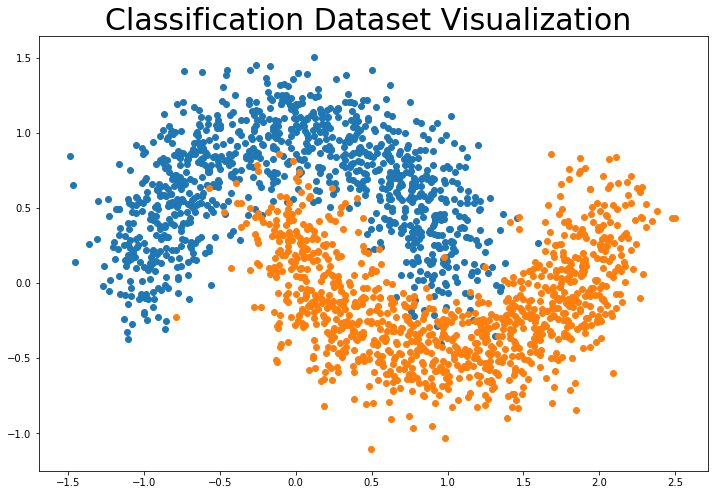

In [4]:
make_plot(X, y, "Classification Dataset Visualization ") 

### 2. 网络层
- 通过新建类 `Layer` 实现一个网络层，需要传入网络层的输入节点数、输出节点数、激 活函数类型等参数
- 权值 `weights` 和偏置张量 `bias` 在初始化时根据输入、输出节点数自动 生成并初始化

In [16]:
class Layer:
    # 全链接网络层
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: 输入节点数 
        :param int n_output: 输出节点数         
        :param str activation: 激活函数类型         
        :param weights: 权值张量，默认类内部生成         
        :param bias: 偏置，默认类内部生成 
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) * np.sqrt(1 / n_output) 
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.1
        self.activation = activation # 激活函数类型，如’sigmoid’         
        self.activation_output = None # 激活函数的输出值 o         
        self.error = None  # 用于计算当前层的 delta 变量的中间变量 
        self.delta = None  # 记录当前层的 delta 变量，用于计算梯度 
    
    def activate(self, X):
        # 前向计算函数
        r = np.dot(X, self.weights) + self.bias # X@W + b
        # 通过激活函数，得到全连接层的输出 o (activation_output)      
        self.activation_output = self._apply_activation(r) 
        return self.activation_output
    
    def _apply_activation(self, r): # 计算激活函数的输出
        if self.activation is None:
            return r # 无激活函数，直接返回
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数， 导数为 1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数
        elif self.activation == 'relu':             
            grad = np.array(r, copy=True)             
            grad[r > 0] = 1.             
            grad[r <= 0] = 0.             
            return grad
        # tanh 函数的导数实现         
        elif self.activation == 'tanh':             
            return 1 - r ** 2 
        # Sigmoid 函数的导数实现         
        elif self.activation == 'sigmoid': 
            return r * (1 - r)
        return r

### 3. 网络模型
- 创建单层网络类后，我们实现网络模型的 `NeuralNetwork` 类
- 它内部维护各层的网络 层 `Layer` 类对象，可以通过 `add_layer` 函数追加网络层，
- 实现创建不同结构的网络模型目 的。

In [17]:
y_test.flatten().shape

(600,)

In [18]:
class NeuralNetwork:
    def __init__(self):
        self._layers = [] # 网络层对象列表
    
    def add_layer(self, layer):
        self._layers.append(layer)
    
    def feed_forward(self, X):
        # 前向传播（求导）
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 向前计算，得到最终输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # 反向循环
            layer = self._layers[i]
            if layer == self._layers[-1]: # 如果是输出层
                layer.error = y - output
                # 计算最后一层的 delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # 如果是隐藏层
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.activation_output)
        
        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].activation_output)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号 
            layer.weights += layer.delta * o_i.T * learning_rate 
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2)) 
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = [] 
        for i in range(max_epochs):  # 训练 100 个 epoch             
            for j in range(len(X_train)):  # 一次训练一个样本                 
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)             
                if i % 10 == 0: 
                    # 打印出 MSE Loss                 
                    mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))                 
                    mses.append(mse)                 
                    print('Epoch: #%s, MSE: %f, Accuracy: %.2f%%' % 
                          (i, float(mse), self.accuracy(self.predict(X_test), y_test.flatten()) * 100)) 

        return mses
    
    def accuracy(self, y_predict, y_test): # 计算准确度
        return np.sum(y_predict == y_test) / len(y_test)
    
    def predict(self, X_predict):
        y_predict = self.feed_forward(X_predict) # 此时的 y_predict 形状是 [600 * 2]，第二个维度表示两个输出的概率
        y_predict = np.argmax(y_predict, axis=1)
        return y_predict        

### 4. 网络训练

In [19]:
nn = NeuralNetwork() # 实例化网络类 
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25 
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层 2, 25=>50 
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层 3, 50=>25 
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2 

In [20]:
nn.train(X_train, X_test, y_train, y_test, learning_rate=0.01, max_epochs=50)

Epoch: #0, MSE: 0.272236, Accuracy: 50.50%
Epoch: #0, MSE: 0.272530, Accuracy: 50.50%
Epoch: #0, MSE: 0.271808, Accuracy: 50.50%
Epoch: #0, MSE: 0.271112, Accuracy: 50.50%
Epoch: #0, MSE: 0.271389, Accuracy: 50.50%
Epoch: #0, MSE: 0.270697, Accuracy: 50.50%
Epoch: #0, MSE: 0.270031, Accuracy: 50.50%
Epoch: #0, MSE: 0.270291, Accuracy: 50.50%
Epoch: #0, MSE: 0.269631, Accuracy: 50.50%
Epoch: #0, MSE: 0.268998, Accuracy: 50.50%
Epoch: #0, MSE: 0.269242, Accuracy: 50.50%
Epoch: #0, MSE: 0.269506, Accuracy: 50.50%
Epoch: #0, MSE: 0.269795, Accuracy: 50.50%
Epoch: #0, MSE: 0.269113, Accuracy: 50.50%
Epoch: #0, MSE: 0.268458, Accuracy: 50.50%
Epoch: #0, MSE: 0.268727, Accuracy: 50.50%
Epoch: #0, MSE: 0.268077, Accuracy: 50.50%
Epoch: #0, MSE: 0.268350, Accuracy: 50.50%
Epoch: #0, MSE: 0.268643, Accuracy: 50.50%
Epoch: #0, MSE: 0.268961, Accuracy: 50.50%
Epoch: #0, MSE: 0.268262, Accuracy: 50.50%
Epoch: #0, MSE: 0.268580, Accuracy: 50.50%
Epoch: #0, MSE: 0.268921, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.252348, Accuracy: 50.50%
Epoch: #0, MSE: 0.252071, Accuracy: 50.50%
Epoch: #0, MSE: 0.252294, Accuracy: 50.50%
Epoch: #0, MSE: 0.252547, Accuracy: 50.50%
Epoch: #0, MSE: 0.252826, Accuracy: 50.50%
Epoch: #0, MSE: 0.252490, Accuracy: 50.50%
Epoch: #0, MSE: 0.252764, Accuracy: 50.50%
Epoch: #0, MSE: 0.253065, Accuracy: 50.50%
Epoch: #0, MSE: 0.252697, Accuracy: 50.50%
Epoch: #0, MSE: 0.252996, Accuracy: 50.50%
Epoch: #0, MSE: 0.252630, Accuracy: 50.50%
Epoch: #0, MSE: 0.252924, Accuracy: 50.50%
Epoch: #0, MSE: 0.252568, Accuracy: 50.50%
Epoch: #0, MSE: 0.252858, Accuracy: 50.50%
Epoch: #0, MSE: 0.252504, Accuracy: 50.50%
Epoch: #0, MSE: 0.252790, Accuracy: 50.50%
Epoch: #0, MSE: 0.252445, Accuracy: 50.50%
Epoch: #0, MSE: 0.252730, Accuracy: 50.50%
Epoch: #0, MSE: 0.253038, Accuracy: 50.50%
Epoch: #0, MSE: 0.252661, Accuracy: 50.50%
Epoch: #0, MSE: 0.252966, Accuracy: 50.50%
Epoch: #0, MSE: 0.253295, Accuracy: 50.50%
Epoch: #0, MSE: 0.253650, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.250843, Accuracy: 49.50%
Epoch: #0, MSE: 0.251039, Accuracy: 49.50%
Epoch: #0, MSE: 0.251263, Accuracy: 49.50%
Epoch: #0, MSE: 0.251514, Accuracy: 49.50%
Epoch: #0, MSE: 0.251220, Accuracy: 49.50%
Epoch: #0, MSE: 0.251466, Accuracy: 49.50%
Epoch: #0, MSE: 0.251738, Accuracy: 49.50%
Epoch: #0, MSE: 0.252035, Accuracy: 49.50%
Epoch: #0, MSE: 0.252355, Accuracy: 49.50%
Epoch: #0, MSE: 0.251965, Accuracy: 49.50%
Epoch: #0, MSE: 0.252279, Accuracy: 49.50%
Epoch: #0, MSE: 0.252616, Accuracy: 49.50%
Epoch: #0, MSE: 0.252976, Accuracy: 49.50%
Epoch: #0, MSE: 0.252526, Accuracy: 49.50%
Epoch: #0, MSE: 0.252881, Accuracy: 49.50%
Epoch: #0, MSE: 0.253257, Accuracy: 49.50%
Epoch: #0, MSE: 0.253653, Accuracy: 49.50%
Epoch: #0, MSE: 0.253145, Accuracy: 49.50%
Epoch: #0, MSE: 0.253536, Accuracy: 49.50%
Epoch: #0, MSE: 0.253037, Accuracy: 49.50%
Epoch: #0, MSE: 0.253422, Accuracy: 49.50%
Epoch: #0, MSE: 0.253828, Accuracy: 49.50%
Epoch: #0, MSE: 0.254254, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.251684, Accuracy: 49.50%
Epoch: #0, MSE: 0.251329, Accuracy: 49.50%
Epoch: #0, MSE: 0.251623, Accuracy: 49.50%
Epoch: #0, MSE: 0.251941, Accuracy: 49.50%
Epoch: #0, MSE: 0.252282, Accuracy: 49.50%
Epoch: #0, MSE: 0.251867, Accuracy: 49.50%
Epoch: #0, MSE: 0.252203, Accuracy: 49.50%
Epoch: #0, MSE: 0.252562, Accuracy: 49.50%
Epoch: #0, MSE: 0.252941, Accuracy: 49.50%
Epoch: #0, MSE: 0.253341, Accuracy: 49.50%
Epoch: #0, MSE: 0.253761, Accuracy: 49.50%
Epoch: #0, MSE: 0.253223, Accuracy: 49.50%
Epoch: #0, MSE: 0.252726, Accuracy: 49.50%
Epoch: #0, MSE: 0.253114, Accuracy: 49.50%
Epoch: #0, MSE: 0.253525, Accuracy: 49.50%
Epoch: #0, MSE: 0.253952, Accuracy: 49.50%
Epoch: #0, MSE: 0.254399, Accuracy: 49.50%
Epoch: #0, MSE: 0.253812, Accuracy: 49.50%
Epoch: #0, MSE: 0.253268, Accuracy: 49.50%
Epoch: #0, MSE: 0.252767, Accuracy: 49.50%
Epoch: #0, MSE: 0.252306, Accuracy: 49.50%
Epoch: #0, MSE: 0.251887, Accuracy: 49.50%
Epoch: #0, MSE: 0.252227, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.249917, Accuracy: 50.50%
Epoch: #0, MSE: 0.249802, Accuracy: 50.50%
Epoch: #0, MSE: 0.249723, Accuracy: 50.50%
Epoch: #0, MSE: 0.249795, Accuracy: 50.50%
Epoch: #0, MSE: 0.249900, Accuracy: 50.50%
Epoch: #0, MSE: 0.250038, Accuracy: 50.50%
Epoch: #0, MSE: 0.250203, Accuracy: 50.50%
Epoch: #0, MSE: 0.250025, Accuracy: 50.50%
Epoch: #0, MSE: 0.249883, Accuracy: 50.50%
Epoch: #0, MSE: 0.250015, Accuracy: 50.50%
Epoch: #0, MSE: 0.250178, Accuracy: 50.50%
Epoch: #0, MSE: 0.250371, Accuracy: 50.50%
Epoch: #0, MSE: 0.250592, Accuracy: 50.50%
Epoch: #0, MSE: 0.250837, Accuracy: 50.50%
Epoch: #0, MSE: 0.251110, Accuracy: 50.50%
Epoch: #0, MSE: 0.251409, Accuracy: 50.50%
Epoch: #0, MSE: 0.251731, Accuracy: 50.50%
Epoch: #0, MSE: 0.252076, Accuracy: 50.50%
Epoch: #0, MSE: 0.251664, Accuracy: 50.50%
Epoch: #0, MSE: 0.251288, Accuracy: 50.50%
Epoch: #0, MSE: 0.250951, Accuracy: 50.50%
Epoch: #0, MSE: 0.251236, Accuracy: 50.50%
Epoch: #0, MSE: 0.251548, Accuracy: 50.50%
Epoch: #0, 

Epoch: #0, MSE: 0.251706, Accuracy: 49.50%
Epoch: #0, MSE: 0.251304, Accuracy: 49.50%
Epoch: #0, MSE: 0.250943, Accuracy: 49.50%
Epoch: #0, MSE: 0.250622, Accuracy: 49.50%
Epoch: #0, MSE: 0.250891, Accuracy: 49.50%
Epoch: #0, MSE: 0.250575, Accuracy: 49.50%
Epoch: #0, MSE: 0.250299, Accuracy: 49.50%
Epoch: #0, MSE: 0.250534, Accuracy: 49.50%
Epoch: #0, MSE: 0.250263, Accuracy: 49.50%
Epoch: #0, MSE: 0.250033, Accuracy: 49.50%
Epoch: #0, MSE: 0.250235, Accuracy: 49.50%
Epoch: #0, MSE: 0.250008, Accuracy: 49.50%
Epoch: #0, MSE: 0.249821, Accuracy: 49.50%
Epoch: #0, MSE: 0.249670, Accuracy: 49.50%
Epoch: #0, MSE: 0.249804, Accuracy: 49.50%
Epoch: #0, MSE: 0.249655, Accuracy: 49.50%
Epoch: #0, MSE: 0.249542, Accuracy: 49.50%
Epoch: #0, MSE: 0.249641, Accuracy: 49.50%
Epoch: #0, MSE: 0.249772, Accuracy: 49.50%
Epoch: #0, MSE: 0.249932, Accuracy: 49.50%
Epoch: #0, MSE: 0.249754, Accuracy: 49.50%
Epoch: #0, MSE: 0.249615, Accuracy: 49.50%
Epoch: #0, MSE: 0.249510, Accuracy: 49.50%
Epoch: #0, 

Epoch: #0, MSE: 0.249736, Accuracy: 50.50%
Epoch: #0, MSE: 0.249932, Accuracy: 50.50%
Epoch: #0, MSE: 0.249715, Accuracy: 50.50%
Epoch: #0, MSE: 0.249907, Accuracy: 50.50%
Epoch: #0, MSE: 0.249691, Accuracy: 50.50%
Epoch: #0, MSE: 0.249886, Accuracy: 50.50%
Epoch: #0, MSE: 0.249677, Accuracy: 50.50%
Epoch: #0, MSE: 0.249504, Accuracy: 50.50%
Epoch: #0, MSE: 0.249661, Accuracy: 50.50%
Epoch: #0, MSE: 0.249847, Accuracy: 50.50%
Epoch: #0, MSE: 0.249644, Accuracy: 50.50%
Epoch: #0, MSE: 0.249832, Accuracy: 50.50%
Epoch: #0, MSE: 0.250047, Accuracy: 50.50%
Epoch: #0, MSE: 0.249809, Accuracy: 50.50%
Epoch: #0, MSE: 0.249608, Accuracy: 50.50%
Epoch: #0, MSE: 0.249448, Accuracy: 50.50%
Epoch: #0, MSE: 0.249324, Accuracy: 50.50%
Epoch: #0, MSE: 0.249437, Accuracy: 50.50%
Epoch: #0, MSE: 0.249313, Accuracy: 50.50%
Epoch: #0, MSE: 0.249429, Accuracy: 50.50%
Epoch: #0, MSE: 0.249576, Accuracy: 50.50%
Epoch: #0, MSE: 0.249749, Accuracy: 50.50%
Epoch: #0, MSE: 0.249558, Accuracy: 50.50%
Epoch: #0, 

Epoch: #10, MSE: 0.183903, Accuracy: 79.67%
Epoch: #10, MSE: 0.184005, Accuracy: 79.83%
Epoch: #10, MSE: 0.183921, Accuracy: 79.67%
Epoch: #10, MSE: 0.183950, Accuracy: 79.83%
Epoch: #10, MSE: 0.183859, Accuracy: 79.50%
Epoch: #10, MSE: 0.183861, Accuracy: 79.50%
Epoch: #10, MSE: 0.183887, Accuracy: 80.50%
Epoch: #10, MSE: 0.183977, Accuracy: 80.83%
Epoch: #10, MSE: 0.183858, Accuracy: 80.17%
Epoch: #10, MSE: 0.183905, Accuracy: 80.67%
Epoch: #10, MSE: 0.183810, Accuracy: 80.50%
Epoch: #10, MSE: 0.183747, Accuracy: 79.50%
Epoch: #10, MSE: 0.183760, Accuracy: 80.50%
Epoch: #10, MSE: 0.183696, Accuracy: 79.50%
Epoch: #10, MSE: 0.183662, Accuracy: 79.50%
Epoch: #10, MSE: 0.183709, Accuracy: 79.83%
Epoch: #10, MSE: 0.183825, Accuracy: 80.83%
Epoch: #10, MSE: 0.183720, Accuracy: 80.67%
Epoch: #10, MSE: 0.183803, Accuracy: 80.83%
Epoch: #10, MSE: 0.183886, Accuracy: 80.83%
Epoch: #10, MSE: 0.183956, Accuracy: 80.83%
Epoch: #10, MSE: 0.183778, Accuracy: 81.00%
Epoch: #10, MSE: 0.183627, Accur

Epoch: #10, MSE: 0.182833, Accuracy: 81.00%
Epoch: #10, MSE: 0.182421, Accuracy: 81.17%
Epoch: #10, MSE: 0.182597, Accuracy: 81.17%
Epoch: #10, MSE: 0.182831, Accuracy: 81.00%
Epoch: #10, MSE: 0.182429, Accuracy: 81.00%
Epoch: #10, MSE: 0.182791, Accuracy: 80.67%
Epoch: #10, MSE: 0.182500, Accuracy: 81.00%
Epoch: #10, MSE: 0.182731, Accuracy: 80.67%
Epoch: #10, MSE: 0.182320, Accuracy: 81.17%
Epoch: #10, MSE: 0.182514, Accuracy: 81.17%
Epoch: #10, MSE: 0.182195, Accuracy: 81.33%
Epoch: #10, MSE: 0.182371, Accuracy: 81.00%
Epoch: #10, MSE: 0.182027, Accuracy: 81.00%
Epoch: #10, MSE: 0.182354, Accuracy: 81.00%
Epoch: #10, MSE: 0.182538, Accuracy: 80.50%
Epoch: #10, MSE: 0.182205, Accuracy: 81.33%
Epoch: #10, MSE: 0.182434, Accuracy: 81.00%
Epoch: #10, MSE: 0.182604, Accuracy: 80.67%
Epoch: #10, MSE: 0.183017, Accuracy: 81.17%
Epoch: #10, MSE: 0.182531, Accuracy: 80.50%
Epoch: #10, MSE: 0.182271, Accuracy: 81.00%
Epoch: #10, MSE: 0.181941, Accuracy: 81.00%
Epoch: #10, MSE: 0.181720, Accur

Epoch: #10, MSE: 0.187337, Accuracy: 78.67%
Epoch: #10, MSE: 0.186282, Accuracy: 78.67%
Epoch: #10, MSE: 0.185412, Accuracy: 79.00%
Epoch: #10, MSE: 0.184692, Accuracy: 79.00%
Epoch: #10, MSE: 0.185305, Accuracy: 79.00%
Epoch: #10, MSE: 0.184561, Accuracy: 79.00%
Epoch: #10, MSE: 0.183883, Accuracy: 79.33%
Epoch: #10, MSE: 0.184270, Accuracy: 79.50%
Epoch: #10, MSE: 0.183422, Accuracy: 79.33%
Epoch: #10, MSE: 0.183830, Accuracy: 79.33%
Epoch: #10, MSE: 0.184308, Accuracy: 79.17%
Epoch: #10, MSE: 0.184725, Accuracy: 78.67%
Epoch: #10, MSE: 0.183997, Accuracy: 79.33%
Epoch: #10, MSE: 0.183165, Accuracy: 79.50%
Epoch: #10, MSE: 0.183706, Accuracy: 79.33%
Epoch: #10, MSE: 0.184024, Accuracy: 79.50%
Epoch: #10, MSE: 0.184671, Accuracy: 78.67%
Epoch: #10, MSE: 0.185389, Accuracy: 78.83%
Epoch: #10, MSE: 0.185758, Accuracy: 78.67%
Epoch: #10, MSE: 0.184685, Accuracy: 78.83%
Epoch: #10, MSE: 0.185309, Accuracy: 78.83%
Epoch: #10, MSE: 0.184384, Accuracy: 79.00%
Epoch: #10, MSE: 0.183329, Accur

Epoch: #10, MSE: 0.179360, Accuracy: 79.83%
Epoch: #10, MSE: 0.180342, Accuracy: 80.33%
Epoch: #10, MSE: 0.180625, Accuracy: 80.00%
Epoch: #10, MSE: 0.181335, Accuracy: 79.33%
Epoch: #10, MSE: 0.180712, Accuracy: 79.67%
Epoch: #10, MSE: 0.179995, Accuracy: 80.33%
Epoch: #10, MSE: 0.179163, Accuracy: 79.67%
Epoch: #10, MSE: 0.178663, Accuracy: 80.17%
Epoch: #10, MSE: 0.177990, Accuracy: 80.17%
Epoch: #10, MSE: 0.178605, Accuracy: 80.17%
Epoch: #10, MSE: 0.178888, Accuracy: 79.83%
Epoch: #10, MSE: 0.179503, Accuracy: 80.17%
Epoch: #10, MSE: 0.178625, Accuracy: 80.00%
Epoch: #10, MSE: 0.178926, Accuracy: 79.67%
Epoch: #10, MSE: 0.179848, Accuracy: 80.50%
Epoch: #10, MSE: 0.178914, Accuracy: 79.83%
Epoch: #10, MSE: 0.179752, Accuracy: 80.17%
Epoch: #10, MSE: 0.180617, Accuracy: 79.67%
Epoch: #10, MSE: 0.179763, Accuracy: 80.33%
Epoch: #10, MSE: 0.180538, Accuracy: 80.00%
Epoch: #10, MSE: 0.179799, Accuracy: 80.50%
Epoch: #10, MSE: 0.178965, Accuracy: 79.67%
Epoch: #10, MSE: 0.178282, Accur

Epoch: #10, MSE: 0.175549, Accuracy: 81.83%
Epoch: #10, MSE: 0.175008, Accuracy: 82.33%
Epoch: #10, MSE: 0.174584, Accuracy: 81.50%
Epoch: #10, MSE: 0.174855, Accuracy: 82.00%
Epoch: #10, MSE: 0.175532, Accuracy: 81.83%
Epoch: #10, MSE: 0.176001, Accuracy: 81.17%
Epoch: #10, MSE: 0.176844, Accuracy: 81.00%
Epoch: #10, MSE: 0.176013, Accuracy: 81.17%
Epoch: #10, MSE: 0.175467, Accuracy: 81.83%
Epoch: #10, MSE: 0.174894, Accuracy: 82.33%
Epoch: #10, MSE: 0.175165, Accuracy: 82.33%
Epoch: #10, MSE: 0.175398, Accuracy: 81.83%
Epoch: #10, MSE: 0.175781, Accuracy: 81.50%
Epoch: #10, MSE: 0.176036, Accuracy: 80.83%
Epoch: #10, MSE: 0.176311, Accuracy: 80.83%
Epoch: #10, MSE: 0.176594, Accuracy: 81.00%
Epoch: #10, MSE: 0.176036, Accuracy: 80.83%
Epoch: #10, MSE: 0.176399, Accuracy: 81.00%
Epoch: #10, MSE: 0.176644, Accuracy: 81.17%
Epoch: #10, MSE: 0.175831, Accuracy: 81.00%
Epoch: #10, MSE: 0.176142, Accuracy: 80.83%
Epoch: #10, MSE: 0.175477, Accuracy: 81.67%
Epoch: #10, MSE: 0.175805, Accur

Epoch: #10, MSE: 0.170530, Accuracy: 80.67%
Epoch: #10, MSE: 0.170349, Accuracy: 80.50%
Epoch: #10, MSE: 0.170470, Accuracy: 80.67%
Epoch: #10, MSE: 0.170256, Accuracy: 80.33%
Epoch: #10, MSE: 0.170051, Accuracy: 80.50%
Epoch: #10, MSE: 0.170169, Accuracy: 79.67%
Epoch: #10, MSE: 0.169996, Accuracy: 80.50%
Epoch: #10, MSE: 0.169892, Accuracy: 79.83%
Epoch: #10, MSE: 0.169844, Accuracy: 79.67%
Epoch: #10, MSE: 0.169837, Accuracy: 79.83%
Epoch: #10, MSE: 0.169794, Accuracy: 79.83%
Epoch: #10, MSE: 0.169766, Accuracy: 79.83%
Epoch: #10, MSE: 0.169746, Accuracy: 80.00%
Epoch: #10, MSE: 0.169751, Accuracy: 80.17%
Epoch: #10, MSE: 0.169769, Accuracy: 80.33%
Epoch: #10, MSE: 0.169694, Accuracy: 79.83%
Epoch: #10, MSE: 0.169675, Accuracy: 79.83%
Epoch: #10, MSE: 0.169666, Accuracy: 79.83%
Epoch: #10, MSE: 0.169681, Accuracy: 80.83%
Epoch: #10, MSE: 0.169845, Accuracy: 81.17%
Epoch: #10, MSE: 0.169734, Accuracy: 81.17%
Epoch: #10, MSE: 0.169909, Accuracy: 81.17%
Epoch: #10, MSE: 0.169718, Accur

Epoch: #10, MSE: 0.167616, Accuracy: 81.50%
Epoch: #10, MSE: 0.167745, Accuracy: 81.50%
Epoch: #10, MSE: 0.167418, Accuracy: 81.33%
Epoch: #10, MSE: 0.167811, Accuracy: 81.50%
Epoch: #10, MSE: 0.168169, Accuracy: 81.33%
Epoch: #10, MSE: 0.167897, Accuracy: 81.83%
Epoch: #10, MSE: 0.167699, Accuracy: 81.50%
Epoch: #10, MSE: 0.167397, Accuracy: 81.33%
Epoch: #10, MSE: 0.167181, Accuracy: 81.17%
Epoch: #10, MSE: 0.167261, Accuracy: 81.33%
Epoch: #10, MSE: 0.167118, Accuracy: 81.17%
Epoch: #10, MSE: 0.167422, Accuracy: 81.17%
Epoch: #10, MSE: 0.167828, Accuracy: 81.83%
Epoch: #10, MSE: 0.167984, Accuracy: 81.33%
Epoch: #10, MSE: 0.167723, Accuracy: 81.67%
Epoch: #10, MSE: 0.167841, Accuracy: 81.50%
Epoch: #10, MSE: 0.168279, Accuracy: 81.67%
Epoch: #10, MSE: 0.167806, Accuracy: 81.50%
Epoch: #10, MSE: 0.167574, Accuracy: 81.50%
Epoch: #10, MSE: 0.167982, Accuracy: 81.33%
Epoch: #10, MSE: 0.167631, Accuracy: 81.50%
Epoch: #10, MSE: 0.167281, Accuracy: 81.33%
Epoch: #10, MSE: 0.167392, Accur

Epoch: #20, MSE: 0.103195, Accuracy: 86.67%
Epoch: #20, MSE: 0.102831, Accuracy: 86.83%
Epoch: #20, MSE: 0.102794, Accuracy: 86.83%
Epoch: #20, MSE: 0.102746, Accuracy: 86.83%
Epoch: #20, MSE: 0.102841, Accuracy: 86.83%
Epoch: #20, MSE: 0.102780, Accuracy: 86.83%
Epoch: #20, MSE: 0.102790, Accuracy: 86.83%
Epoch: #20, MSE: 0.102816, Accuracy: 86.83%
Epoch: #20, MSE: 0.102806, Accuracy: 86.83%
Epoch: #20, MSE: 0.102892, Accuracy: 86.83%
Epoch: #20, MSE: 0.102898, Accuracy: 86.83%
Epoch: #20, MSE: 0.102635, Accuracy: 87.00%
Epoch: #20, MSE: 0.102550, Accuracy: 87.17%
Epoch: #20, MSE: 0.102556, Accuracy: 87.17%
Epoch: #20, MSE: 0.102532, Accuracy: 87.17%
Epoch: #20, MSE: 0.102523, Accuracy: 87.17%
Epoch: #20, MSE: 0.102521, Accuracy: 87.17%
Epoch: #20, MSE: 0.102543, Accuracy: 87.17%
Epoch: #20, MSE: 0.102555, Accuracy: 87.17%
Epoch: #20, MSE: 0.102585, Accuracy: 87.00%
Epoch: #20, MSE: 0.102598, Accuracy: 87.00%
Epoch: #20, MSE: 0.102603, Accuracy: 87.00%
Epoch: #20, MSE: 0.102808, Accur

Epoch: #20, MSE: 0.102786, Accuracy: 87.83%
Epoch: #20, MSE: 0.102920, Accuracy: 88.00%
Epoch: #20, MSE: 0.102899, Accuracy: 88.00%
Epoch: #20, MSE: 0.102965, Accuracy: 88.00%
Epoch: #20, MSE: 0.102615, Accuracy: 87.83%
Epoch: #20, MSE: 0.102624, Accuracy: 87.83%
Epoch: #20, MSE: 0.102584, Accuracy: 87.67%
Epoch: #20, MSE: 0.102595, Accuracy: 87.67%
Epoch: #20, MSE: 0.102349, Accuracy: 87.67%
Epoch: #20, MSE: 0.102437, Accuracy: 88.00%
Epoch: #20, MSE: 0.102441, Accuracy: 88.00%
Epoch: #20, MSE: 0.102424, Accuracy: 88.00%
Epoch: #20, MSE: 0.102437, Accuracy: 88.00%
Epoch: #20, MSE: 0.102454, Accuracy: 88.00%
Epoch: #20, MSE: 0.102501, Accuracy: 87.83%
Epoch: #20, MSE: 0.102338, Accuracy: 87.83%
Epoch: #20, MSE: 0.102333, Accuracy: 87.83%
Epoch: #20, MSE: 0.102298, Accuracy: 87.67%
Epoch: #20, MSE: 0.102280, Accuracy: 87.67%
Epoch: #20, MSE: 0.102471, Accuracy: 87.83%
Epoch: #20, MSE: 0.102302, Accuracy: 87.67%
Epoch: #20, MSE: 0.102291, Accuracy: 87.67%
Epoch: #20, MSE: 0.102317, Accur

Epoch: #20, MSE: 0.103793, Accuracy: 87.33%
Epoch: #20, MSE: 0.103835, Accuracy: 87.33%
Epoch: #20, MSE: 0.103893, Accuracy: 87.33%
Epoch: #20, MSE: 0.103878, Accuracy: 87.33%
Epoch: #20, MSE: 0.103949, Accuracy: 87.33%
Epoch: #20, MSE: 0.104402, Accuracy: 86.67%
Epoch: #20, MSE: 0.105116, Accuracy: 87.17%
Epoch: #20, MSE: 0.104791, Accuracy: 86.83%
Epoch: #20, MSE: 0.104824, Accuracy: 86.83%
Epoch: #20, MSE: 0.104752, Accuracy: 86.83%
Epoch: #20, MSE: 0.104795, Accuracy: 86.83%
Epoch: #20, MSE: 0.104863, Accuracy: 86.83%
Epoch: #20, MSE: 0.104894, Accuracy: 86.83%
Epoch: #20, MSE: 0.105272, Accuracy: 87.00%
Epoch: #20, MSE: 0.105291, Accuracy: 87.00%
Epoch: #20, MSE: 0.105349, Accuracy: 87.17%
Epoch: #20, MSE: 0.105278, Accuracy: 87.00%
Epoch: #20, MSE: 0.105019, Accuracy: 87.17%
Epoch: #20, MSE: 0.105036, Accuracy: 87.17%
Epoch: #20, MSE: 0.105379, Accuracy: 87.17%
Epoch: #20, MSE: 0.105315, Accuracy: 87.00%
Epoch: #20, MSE: 0.105215, Accuracy: 87.00%
Epoch: #20, MSE: 0.105191, Accur

Epoch: #20, MSE: 0.102546, Accuracy: 86.67%
Epoch: #20, MSE: 0.102697, Accuracy: 86.83%
Epoch: #20, MSE: 0.103214, Accuracy: 87.33%
Epoch: #20, MSE: 0.103235, Accuracy: 87.50%
Epoch: #20, MSE: 0.103406, Accuracy: 87.33%
Epoch: #20, MSE: 0.103438, Accuracy: 87.33%
Epoch: #20, MSE: 0.102863, Accuracy: 87.00%
Epoch: #20, MSE: 0.102590, Accuracy: 86.67%
Epoch: #20, MSE: 0.102595, Accuracy: 86.67%
Epoch: #20, MSE: 0.102893, Accuracy: 87.00%
Epoch: #20, MSE: 0.102899, Accuracy: 87.00%
Epoch: #20, MSE: 0.103175, Accuracy: 87.33%
Epoch: #20, MSE: 0.103156, Accuracy: 87.33%
Epoch: #20, MSE: 0.103136, Accuracy: 87.33%
Epoch: #20, MSE: 0.103065, Accuracy: 87.17%
Epoch: #20, MSE: 0.103056, Accuracy: 87.17%
Epoch: #20, MSE: 0.102976, Accuracy: 87.17%
Epoch: #20, MSE: 0.103240, Accuracy: 87.50%
Epoch: #20, MSE: 0.103259, Accuracy: 87.50%
Epoch: #20, MSE: 0.103330, Accuracy: 87.33%
Epoch: #20, MSE: 0.103007, Accuracy: 87.17%
Epoch: #20, MSE: 0.103016, Accuracy: 87.17%
Epoch: #20, MSE: 0.103548, Accur

Epoch: #20, MSE: 0.101708, Accuracy: 87.83%
Epoch: #20, MSE: 0.101717, Accuracy: 87.83%
Epoch: #20, MSE: 0.101777, Accuracy: 88.00%
Epoch: #20, MSE: 0.101786, Accuracy: 88.00%
Epoch: #20, MSE: 0.101633, Accuracy: 87.50%
Epoch: #20, MSE: 0.101618, Accuracy: 87.50%
Epoch: #20, MSE: 0.101634, Accuracy: 87.50%
Epoch: #20, MSE: 0.101710, Accuracy: 87.83%
Epoch: #20, MSE: 0.101754, Accuracy: 88.00%
Epoch: #20, MSE: 0.101988, Accuracy: 88.00%
Epoch: #20, MSE: 0.101992, Accuracy: 88.00%
Epoch: #20, MSE: 0.101996, Accuracy: 88.00%
Epoch: #20, MSE: 0.102026, Accuracy: 88.00%
Epoch: #20, MSE: 0.102132, Accuracy: 88.00%
Epoch: #20, MSE: 0.102134, Accuracy: 88.00%
Epoch: #20, MSE: 0.101989, Accuracy: 88.00%
Epoch: #20, MSE: 0.101790, Accuracy: 88.00%
Epoch: #20, MSE: 0.101777, Accuracy: 88.00%
Epoch: #20, MSE: 0.101782, Accuracy: 88.00%
Epoch: #20, MSE: 0.102022, Accuracy: 88.00%
Epoch: #20, MSE: 0.102050, Accuracy: 87.83%
Epoch: #20, MSE: 0.102430, Accuracy: 87.83%
Epoch: #20, MSE: 0.102228, Accur

Epoch: #20, MSE: 0.101837, Accuracy: 87.00%
Epoch: #20, MSE: 0.101830, Accuracy: 87.00%
Epoch: #20, MSE: 0.101687, Accuracy: 87.00%
Epoch: #20, MSE: 0.101508, Accuracy: 87.33%
Epoch: #20, MSE: 0.101468, Accuracy: 87.50%
Epoch: #20, MSE: 0.101492, Accuracy: 87.33%
Epoch: #20, MSE: 0.101456, Accuracy: 87.50%
Epoch: #20, MSE: 0.101452, Accuracy: 87.50%
Epoch: #20, MSE: 0.101499, Accuracy: 87.33%
Epoch: #20, MSE: 0.101483, Accuracy: 87.50%
Epoch: #20, MSE: 0.101376, Accuracy: 87.50%
Epoch: #20, MSE: 0.101384, Accuracy: 87.50%
Epoch: #20, MSE: 0.101370, Accuracy: 87.50%
Epoch: #20, MSE: 0.101344, Accuracy: 87.50%
Epoch: #20, MSE: 0.101343, Accuracy: 87.50%
Epoch: #20, MSE: 0.101343, Accuracy: 87.50%
Epoch: #20, MSE: 0.101343, Accuracy: 87.50%
Epoch: #20, MSE: 0.101342, Accuracy: 87.50%
Epoch: #20, MSE: 0.101342, Accuracy: 87.50%
Epoch: #20, MSE: 0.101340, Accuracy: 87.50%
Epoch: #20, MSE: 0.101340, Accuracy: 87.50%
Epoch: #20, MSE: 0.101340, Accuracy: 87.50%
Epoch: #20, MSE: 0.101355, Accur

Epoch: #20, MSE: 0.103697, Accuracy: 88.33%
Epoch: #20, MSE: 0.103655, Accuracy: 88.33%
Epoch: #20, MSE: 0.103360, Accuracy: 88.33%
Epoch: #20, MSE: 0.103301, Accuracy: 88.33%
Epoch: #20, MSE: 0.103392, Accuracy: 88.33%
Epoch: #20, MSE: 0.103179, Accuracy: 88.33%
Epoch: #20, MSE: 0.103939, Accuracy: 88.33%
Epoch: #20, MSE: 0.104836, Accuracy: 88.50%
Epoch: #20, MSE: 0.104867, Accuracy: 88.50%
Epoch: #20, MSE: 0.104819, Accuracy: 88.50%
Epoch: #20, MSE: 0.104828, Accuracy: 88.50%
Epoch: #20, MSE: 0.105376, Accuracy: 88.33%
Epoch: #20, MSE: 0.104693, Accuracy: 88.50%
Epoch: #20, MSE: 0.104463, Accuracy: 88.50%
Epoch: #20, MSE: 0.105067, Accuracy: 88.33%
Epoch: #20, MSE: 0.104937, Accuracy: 88.50%
Epoch: #20, MSE: 0.104257, Accuracy: 88.50%
Epoch: #20, MSE: 0.104275, Accuracy: 88.50%
Epoch: #20, MSE: 0.104434, Accuracy: 88.50%
Epoch: #20, MSE: 0.104463, Accuracy: 88.50%
Epoch: #20, MSE: 0.104250, Accuracy: 88.50%
Epoch: #20, MSE: 0.103905, Accuracy: 88.50%
Epoch: #20, MSE: 0.103952, Accur

Epoch: #30, MSE: 0.097209, Accuracy: 88.33%
Epoch: #30, MSE: 0.097210, Accuracy: 88.33%
Epoch: #30, MSE: 0.097155, Accuracy: 88.33%
Epoch: #30, MSE: 0.096814, Accuracy: 88.17%
Epoch: #30, MSE: 0.096802, Accuracy: 88.17%
Epoch: #30, MSE: 0.096787, Accuracy: 88.33%
Epoch: #30, MSE: 0.096839, Accuracy: 88.33%
Epoch: #30, MSE: 0.096781, Accuracy: 88.33%
Epoch: #30, MSE: 0.096785, Accuracy: 88.33%
Epoch: #30, MSE: 0.096805, Accuracy: 88.17%
Epoch: #30, MSE: 0.096803, Accuracy: 88.17%
Epoch: #30, MSE: 0.096926, Accuracy: 88.17%
Epoch: #30, MSE: 0.096928, Accuracy: 88.17%
Epoch: #30, MSE: 0.096667, Accuracy: 88.50%
Epoch: #30, MSE: 0.096638, Accuracy: 88.50%
Epoch: #30, MSE: 0.096641, Accuracy: 88.50%
Epoch: #30, MSE: 0.096629, Accuracy: 88.50%
Epoch: #30, MSE: 0.096623, Accuracy: 88.67%
Epoch: #30, MSE: 0.096623, Accuracy: 88.67%
Epoch: #30, MSE: 0.096645, Accuracy: 88.50%
Epoch: #30, MSE: 0.096648, Accuracy: 88.50%
Epoch: #30, MSE: 0.096659, Accuracy: 88.50%
Epoch: #30, MSE: 0.096671, Accur

Epoch: #30, MSE: 0.096493, Accuracy: 88.83%
Epoch: #30, MSE: 0.096510, Accuracy: 88.83%
Epoch: #30, MSE: 0.096510, Accuracy: 88.83%
Epoch: #30, MSE: 0.096509, Accuracy: 88.83%
Epoch: #30, MSE: 0.096511, Accuracy: 88.83%
Epoch: #30, MSE: 0.096517, Accuracy: 88.83%
Epoch: #30, MSE: 0.096524, Accuracy: 88.83%
Epoch: #30, MSE: 0.096490, Accuracy: 88.83%
Epoch: #30, MSE: 0.096489, Accuracy: 88.83%
Epoch: #30, MSE: 0.096486, Accuracy: 88.83%
Epoch: #30, MSE: 0.096483, Accuracy: 88.83%
Epoch: #30, MSE: 0.096555, Accuracy: 88.83%
Epoch: #30, MSE: 0.096487, Accuracy: 88.83%
Epoch: #30, MSE: 0.096486, Accuracy: 88.83%
Epoch: #30, MSE: 0.096490, Accuracy: 88.83%
Epoch: #30, MSE: 0.096617, Accuracy: 88.83%
Epoch: #30, MSE: 0.096607, Accuracy: 88.83%
Epoch: #30, MSE: 0.096509, Accuracy: 88.83%
Epoch: #30, MSE: 0.096478, Accuracy: 88.83%
Epoch: #30, MSE: 0.096478, Accuracy: 88.83%
Epoch: #30, MSE: 0.096477, Accuracy: 88.83%
Epoch: #30, MSE: 0.096478, Accuracy: 88.83%
Epoch: #30, MSE: 0.096476, Accur

Epoch: #30, MSE: 0.098088, Accuracy: 88.67%
Epoch: #30, MSE: 0.098077, Accuracy: 88.67%
Epoch: #30, MSE: 0.098090, Accuracy: 88.67%
Epoch: #30, MSE: 0.098092, Accuracy: 88.67%
Epoch: #30, MSE: 0.098155, Accuracy: 88.67%
Epoch: #30, MSE: 0.098310, Accuracy: 88.83%
Epoch: #30, MSE: 0.098315, Accuracy: 88.83%
Epoch: #30, MSE: 0.098254, Accuracy: 88.83%
Epoch: #30, MSE: 0.098305, Accuracy: 88.83%
Epoch: #30, MSE: 0.098062, Accuracy: 88.67%
Epoch: #30, MSE: 0.097974, Accuracy: 88.50%
Epoch: #30, MSE: 0.097938, Accuracy: 88.50%
Epoch: #30, MSE: 0.097467, Accuracy: 88.50%
Epoch: #30, MSE: 0.097445, Accuracy: 88.50%
Epoch: #30, MSE: 0.097413, Accuracy: 88.33%
Epoch: #30, MSE: 0.097408, Accuracy: 88.33%
Epoch: #30, MSE: 0.097248, Accuracy: 88.33%
Epoch: #30, MSE: 0.097254, Accuracy: 88.33%
Epoch: #30, MSE: 0.096934, Accuracy: 88.33%
Epoch: #30, MSE: 0.096946, Accuracy: 88.33%
Epoch: #30, MSE: 0.097117, Accuracy: 88.33%
Epoch: #30, MSE: 0.096824, Accuracy: 88.33%
Epoch: #30, MSE: 0.096819, Accur

Epoch: #30, MSE: 0.098055, Accuracy: 88.67%
Epoch: #30, MSE: 0.098067, Accuracy: 88.67%
Epoch: #30, MSE: 0.098047, Accuracy: 88.67%
Epoch: #30, MSE: 0.098052, Accuracy: 88.67%
Epoch: #30, MSE: 0.098619, Accuracy: 88.83%
Epoch: #30, MSE: 0.098624, Accuracy: 88.83%
Epoch: #30, MSE: 0.098570, Accuracy: 88.83%
Epoch: #30, MSE: 0.098558, Accuracy: 88.83%
Epoch: #30, MSE: 0.098544, Accuracy: 88.83%
Epoch: #30, MSE: 0.097958, Accuracy: 88.67%
Epoch: #30, MSE: 0.097966, Accuracy: 88.67%
Epoch: #30, MSE: 0.098536, Accuracy: 88.83%
Epoch: #30, MSE: 0.098482, Accuracy: 88.83%
Epoch: #30, MSE: 0.098494, Accuracy: 88.83%
Epoch: #30, MSE: 0.098250, Accuracy: 88.83%
Epoch: #30, MSE: 0.098268, Accuracy: 88.83%
Epoch: #30, MSE: 0.098192, Accuracy: 88.83%
Epoch: #30, MSE: 0.098248, Accuracy: 88.83%
Epoch: #30, MSE: 0.097666, Accuracy: 88.50%
Epoch: #30, MSE: 0.097710, Accuracy: 88.50%
Epoch: #30, MSE: 0.097268, Accuracy: 88.33%
Epoch: #30, MSE: 0.097270, Accuracy: 88.33%
Epoch: #30, MSE: 0.097595, Accur

Epoch: #30, MSE: 0.096781, Accuracy: 88.67%
Epoch: #30, MSE: 0.096783, Accuracy: 88.67%
Epoch: #30, MSE: 0.096700, Accuracy: 88.67%
Epoch: #30, MSE: 0.096710, Accuracy: 88.67%
Epoch: #30, MSE: 0.096542, Accuracy: 88.83%
Epoch: #30, MSE: 0.096540, Accuracy: 88.83%
Epoch: #30, MSE: 0.096552, Accuracy: 88.83%
Epoch: #30, MSE: 0.096547, Accuracy: 88.83%
Epoch: #30, MSE: 0.096546, Accuracy: 88.83%
Epoch: #30, MSE: 0.096544, Accuracy: 88.83%
Epoch: #30, MSE: 0.096543, Accuracy: 88.83%
Epoch: #30, MSE: 0.096475, Accuracy: 88.83%
Epoch: #30, MSE: 0.096474, Accuracy: 88.83%
Epoch: #30, MSE: 0.096475, Accuracy: 88.83%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096470, Accuracy: 88.67%
Epoch: #30, MSE: 0.096469, Accur

Epoch: #30, MSE: 0.096471, Accuracy: 89.00%
Epoch: #30, MSE: 0.096472, Accuracy: 89.00%
Epoch: #30, MSE: 0.096594, Accuracy: 88.67%
Epoch: #30, MSE: 0.096687, Accuracy: 88.33%
Epoch: #30, MSE: 0.096515, Accuracy: 88.67%
Epoch: #30, MSE: 0.096516, Accuracy: 88.83%
Epoch: #30, MSE: 0.096677, Accuracy: 88.33%
Epoch: #30, MSE: 0.096678, Accuracy: 88.33%
Epoch: #30, MSE: 0.096665, Accuracy: 88.33%
Epoch: #30, MSE: 0.096676, Accuracy: 88.33%
Epoch: #30, MSE: 0.096641, Accuracy: 88.33%
Epoch: #30, MSE: 0.096518, Accuracy: 88.83%
Epoch: #30, MSE: 0.096483, Accuracy: 89.00%
Epoch: #30, MSE: 0.096503, Accuracy: 88.67%
Epoch: #30, MSE: 0.096502, Accuracy: 88.67%
Epoch: #30, MSE: 0.096536, Accuracy: 88.83%
Epoch: #30, MSE: 0.096512, Accuracy: 88.83%
Epoch: #30, MSE: 0.096515, Accuracy: 88.83%
Epoch: #30, MSE: 0.096516, Accuracy: 88.83%
Epoch: #30, MSE: 0.096517, Accuracy: 88.83%
Epoch: #30, MSE: 0.096525, Accuracy: 88.83%
Epoch: #30, MSE: 0.096526, Accuracy: 88.83%
Epoch: #30, MSE: 0.096463, Accur

Epoch: #30, MSE: 0.100034, Accuracy: 88.33%
Epoch: #30, MSE: 0.100037, Accuracy: 88.33%
Epoch: #30, MSE: 0.099725, Accuracy: 88.33%
Epoch: #30, MSE: 0.099769, Accuracy: 88.33%
Epoch: #30, MSE: 0.100556, Accuracy: 88.33%
Epoch: #30, MSE: 0.100540, Accuracy: 88.33%
Epoch: #30, MSE: 0.099843, Accuracy: 88.33%
Epoch: #30, MSE: 0.099339, Accuracy: 88.67%
Epoch: #30, MSE: 0.099320, Accuracy: 88.67%
Epoch: #30, MSE: 0.099327, Accuracy: 88.67%
Epoch: #30, MSE: 0.098714, Accuracy: 88.83%
Epoch: #30, MSE: 0.098717, Accuracy: 88.83%
Epoch: #30, MSE: 0.098552, Accuracy: 88.83%
Epoch: #30, MSE: 0.098361, Accuracy: 88.83%
Epoch: #30, MSE: 0.098884, Accuracy: 88.83%
Epoch: #30, MSE: 0.098909, Accuracy: 88.83%
Epoch: #30, MSE: 0.098912, Accuracy: 88.83%
Epoch: #30, MSE: 0.098914, Accuracy: 88.83%
Epoch: #30, MSE: 0.098945, Accuracy: 88.83%
Epoch: #30, MSE: 0.098916, Accuracy: 88.83%
Epoch: #30, MSE: 0.099727, Accuracy: 88.33%
Epoch: #30, MSE: 0.100513, Accuracy: 88.33%
Epoch: #30, MSE: 0.099645, Accur

Epoch: #40, MSE: 0.096351, Accuracy: 89.00%
Epoch: #40, MSE: 0.096359, Accuracy: 88.83%
Epoch: #40, MSE: 0.096368, Accuracy: 88.83%
Epoch: #40, MSE: 0.096369, Accuracy: 88.83%
Epoch: #40, MSE: 0.096627, Accuracy: 88.67%
Epoch: #40, MSE: 0.096431, Accuracy: 88.83%
Epoch: #40, MSE: 0.096702, Accuracy: 88.67%
Epoch: #40, MSE: 0.096708, Accuracy: 88.67%
Epoch: #40, MSE: 0.096731, Accuracy: 88.67%
Epoch: #40, MSE: 0.096754, Accuracy: 88.67%
Epoch: #40, MSE: 0.096752, Accuracy: 88.67%
Epoch: #40, MSE: 0.096661, Accuracy: 88.67%
Epoch: #40, MSE: 0.096950, Accuracy: 88.33%
Epoch: #40, MSE: 0.096947, Accuracy: 88.33%
Epoch: #40, MSE: 0.096885, Accuracy: 88.33%
Epoch: #40, MSE: 0.096547, Accuracy: 88.50%
Epoch: #40, MSE: 0.096545, Accuracy: 88.50%
Epoch: #40, MSE: 0.096546, Accuracy: 88.50%
Epoch: #40, MSE: 0.096548, Accuracy: 88.50%
Epoch: #40, MSE: 0.096591, Accuracy: 88.50%
Epoch: #40, MSE: 0.096588, Accuracy: 88.50%
Epoch: #40, MSE: 0.096746, Accuracy: 88.67%
Epoch: #40, MSE: 0.096721, Accur

Epoch: #40, MSE: 0.096205, Accuracy: 88.83%
Epoch: #40, MSE: 0.096203, Accuracy: 88.83%
Epoch: #40, MSE: 0.096219, Accuracy: 89.00%
Epoch: #40, MSE: 0.096204, Accuracy: 88.83%
Epoch: #40, MSE: 0.096204, Accuracy: 88.83%
Epoch: #40, MSE: 0.096204, Accuracy: 88.83%
Epoch: #40, MSE: 0.096204, Accuracy: 88.83%
Epoch: #40, MSE: 0.096213, Accuracy: 89.00%
Epoch: #40, MSE: 0.096202, Accuracy: 88.83%
Epoch: #40, MSE: 0.096203, Accuracy: 88.83%
Epoch: #40, MSE: 0.096293, Accuracy: 88.83%
Epoch: #40, MSE: 0.096289, Accuracy: 88.83%
Epoch: #40, MSE: 0.096205, Accuracy: 88.83%
Epoch: #40, MSE: 0.096209, Accuracy: 88.83%
Epoch: #40, MSE: 0.096208, Accuracy: 88.83%
Epoch: #40, MSE: 0.096216, Accuracy: 88.83%
Epoch: #40, MSE: 0.096217, Accuracy: 88.83%
Epoch: #40, MSE: 0.096238, Accuracy: 88.83%
Epoch: #40, MSE: 0.096253, Accuracy: 88.83%
Epoch: #40, MSE: 0.096250, Accuracy: 88.83%
Epoch: #40, MSE: 0.096251, Accuracy: 88.83%
Epoch: #40, MSE: 0.096238, Accuracy: 88.83%
Epoch: #40, MSE: 0.096235, Accur

Epoch: #40, MSE: 0.097598, Accuracy: 88.83%
Epoch: #40, MSE: 0.097615, Accuracy: 88.83%
Epoch: #40, MSE: 0.097626, Accuracy: 88.83%
Epoch: #40, MSE: 0.097613, Accuracy: 88.83%
Epoch: #40, MSE: 0.097606, Accuracy: 88.83%
Epoch: #40, MSE: 0.097614, Accuracy: 88.83%
Epoch: #40, MSE: 0.097615, Accuracy: 88.83%
Epoch: #40, MSE: 0.097663, Accuracy: 89.00%
Epoch: #40, MSE: 0.097792, Accuracy: 88.83%
Epoch: #40, MSE: 0.097796, Accuracy: 88.83%
Epoch: #40, MSE: 0.097754, Accuracy: 88.83%
Epoch: #40, MSE: 0.097792, Accuracy: 88.83%
Epoch: #40, MSE: 0.097581, Accuracy: 88.67%
Epoch: #40, MSE: 0.097520, Accuracy: 88.67%
Epoch: #40, MSE: 0.097495, Accuracy: 88.67%
Epoch: #40, MSE: 0.097071, Accuracy: 88.50%
Epoch: #40, MSE: 0.097056, Accuracy: 88.50%
Epoch: #40, MSE: 0.097033, Accuracy: 88.50%
Epoch: #40, MSE: 0.097030, Accuracy: 88.50%
Epoch: #40, MSE: 0.096903, Accuracy: 88.33%
Epoch: #40, MSE: 0.096908, Accuracy: 88.33%
Epoch: #40, MSE: 0.096620, Accuracy: 88.67%
Epoch: #40, MSE: 0.096628, Accur

Epoch: #40, MSE: 0.097702, Accuracy: 89.00%
Epoch: #40, MSE: 0.097613, Accuracy: 89.00%
Epoch: #40, MSE: 0.097585, Accuracy: 89.00%
Epoch: #40, MSE: 0.097592, Accuracy: 89.00%
Epoch: #40, MSE: 0.097578, Accuracy: 89.00%
Epoch: #40, MSE: 0.097581, Accuracy: 89.00%
Epoch: #40, MSE: 0.098072, Accuracy: 88.83%
Epoch: #40, MSE: 0.098076, Accuracy: 88.83%
Epoch: #40, MSE: 0.098037, Accuracy: 88.83%
Epoch: #40, MSE: 0.098029, Accuracy: 88.83%
Epoch: #40, MSE: 0.098020, Accuracy: 88.83%
Epoch: #40, MSE: 0.097490, Accuracy: 88.67%
Epoch: #40, MSE: 0.097495, Accuracy: 88.67%
Epoch: #40, MSE: 0.097994, Accuracy: 88.83%
Epoch: #40, MSE: 0.097955, Accuracy: 88.83%
Epoch: #40, MSE: 0.097963, Accuracy: 88.83%
Epoch: #40, MSE: 0.097777, Accuracy: 89.00%
Epoch: #40, MSE: 0.097791, Accuracy: 89.00%
Epoch: #40, MSE: 0.097737, Accuracy: 89.00%
Epoch: #40, MSE: 0.097785, Accuracy: 89.00%
Epoch: #40, MSE: 0.097253, Accuracy: 88.67%
Epoch: #40, MSE: 0.097288, Accuracy: 88.67%
Epoch: #40, MSE: 0.096895, Accur

Epoch: #40, MSE: 0.096332, Accuracy: 88.83%
Epoch: #40, MSE: 0.096334, Accuracy: 88.83%
Epoch: #40, MSE: 0.096337, Accuracy: 88.83%
Epoch: #40, MSE: 0.096338, Accuracy: 88.83%
Epoch: #40, MSE: 0.096340, Accuracy: 88.83%
Epoch: #40, MSE: 0.096342, Accuracy: 88.83%
Epoch: #40, MSE: 0.096339, Accuracy: 88.83%
Epoch: #40, MSE: 0.096527, Accuracy: 88.83%
Epoch: #40, MSE: 0.096531, Accuracy: 88.83%
Epoch: #40, MSE: 0.096476, Accuracy: 88.83%
Epoch: #40, MSE: 0.096477, Accuracy: 88.83%
Epoch: #40, MSE: 0.096472, Accuracy: 88.83%
Epoch: #40, MSE: 0.096473, Accuracy: 88.83%
Epoch: #40, MSE: 0.096408, Accuracy: 88.83%
Epoch: #40, MSE: 0.096415, Accuracy: 88.83%
Epoch: #40, MSE: 0.096264, Accuracy: 88.83%
Epoch: #40, MSE: 0.096263, Accuracy: 88.83%
Epoch: #40, MSE: 0.096273, Accuracy: 88.83%
Epoch: #40, MSE: 0.096269, Accuracy: 88.83%
Epoch: #40, MSE: 0.096269, Accuracy: 88.83%
Epoch: #40, MSE: 0.096268, Accuracy: 88.83%
Epoch: #40, MSE: 0.096267, Accuracy: 88.83%
Epoch: #40, MSE: 0.096208, Accur

Epoch: #40, MSE: 0.096225, Accuracy: 88.83%
Epoch: #40, MSE: 0.096224, Accuracy: 88.83%
Epoch: #40, MSE: 0.096225, Accuracy: 88.83%
Epoch: #40, MSE: 0.096224, Accuracy: 88.83%
Epoch: #40, MSE: 0.096223, Accuracy: 88.83%
Epoch: #40, MSE: 0.096225, Accuracy: 88.83%
Epoch: #40, MSE: 0.096226, Accuracy: 88.83%
Epoch: #40, MSE: 0.096227, Accuracy: 88.83%
Epoch: #40, MSE: 0.096223, Accuracy: 88.83%
Epoch: #40, MSE: 0.096202, Accuracy: 88.83%
Epoch: #40, MSE: 0.096201, Accuracy: 88.83%
Epoch: #40, MSE: 0.096198, Accuracy: 88.67%
Epoch: #40, MSE: 0.096221, Accuracy: 88.83%
Epoch: #40, MSE: 0.096220, Accuracy: 88.83%
Epoch: #40, MSE: 0.096234, Accuracy: 88.83%
Epoch: #40, MSE: 0.096229, Accuracy: 88.83%
Epoch: #40, MSE: 0.096226, Accuracy: 88.83%
Epoch: #40, MSE: 0.096227, Accuracy: 88.83%
Epoch: #40, MSE: 0.096226, Accuracy: 88.83%
Epoch: #40, MSE: 0.096195, Accuracy: 88.67%
Epoch: #40, MSE: 0.096195, Accuracy: 88.67%
Epoch: #40, MSE: 0.096195, Accuracy: 88.67%
Epoch: #40, MSE: 0.096203, Accur

Epoch: #40, MSE: 0.099115, Accuracy: 88.50%
Epoch: #40, MSE: 0.099028, Accuracy: 88.50%
Epoch: #40, MSE: 0.099009, Accuracy: 88.50%
Epoch: #40, MSE: 0.098850, Accuracy: 88.50%
Epoch: #40, MSE: 0.098840, Accuracy: 88.50%
Epoch: #40, MSE: 0.098950, Accuracy: 88.50%
Epoch: #40, MSE: 0.098588, Accuracy: 88.33%
Epoch: #40, MSE: 0.099378, Accuracy: 88.50%
Epoch: #40, MSE: 0.100297, Accuracy: 87.83%
Epoch: #40, MSE: 0.100310, Accuracy: 87.83%
Epoch: #40, MSE: 0.100298, Accuracy: 87.83%
Epoch: #40, MSE: 0.100301, Accuracy: 87.83%
Epoch: #40, MSE: 0.100687, Accuracy: 87.83%
Epoch: #40, MSE: 0.100244, Accuracy: 87.83%
Epoch: #40, MSE: 0.099930, Accuracy: 88.00%
Epoch: #40, MSE: 0.100380, Accuracy: 87.83%
Epoch: #40, MSE: 0.100348, Accuracy: 87.83%
Epoch: #40, MSE: 0.099890, Accuracy: 88.17%
Epoch: #40, MSE: 0.099895, Accuracy: 88.17%
Epoch: #40, MSE: 0.099958, Accuracy: 88.00%
Epoch: #40, MSE: 0.099970, Accuracy: 88.00%
Epoch: #40, MSE: 0.099896, Accuracy: 88.17%
Epoch: #40, MSE: 0.099745, Accur

[0.272236470804807,
 0.2725301678291823,
 0.27180791962822864,
 0.2711117274273663,
 0.2713889146177238,
 0.27069730728317154,
 0.27003064510087177,
 0.2702905240277246,
 0.26963059863361794,
 0.2689975287471536,
 0.2692418463053889,
 0.26950610424681426,
 0.2697951773644783,
 0.26911294702765337,
 0.2684584276880929,
 0.26872685401323354,
 0.2680771334721391,
 0.26834999804319476,
 0.26864299712717105,
 0.2689605004714344,
 0.26826159650197545,
 0.268580020347909,
 0.26892078411218756,
 0.26927843394070033,
 0.26853424330662423,
 0.2688929095502409,
 0.26927126536318413,
 0.26850965756473705,
 0.26777606033627066,
 0.26813667783399425,
 0.2685162429342367,
 0.267759580855334,
 0.2670403831100507,
 0.26739917424470233,
 0.26667851852745256,
 0.2670394042325417,
 0.2674212073997485,
 0.26782030996304823,
 0.2682380484179883,
 0.26744864540357466,
 0.26786746626640223,
 0.2670806485911288,
 0.2663272854507956,
 0.2667229985274014,
 0.2659767044407185,
 0.2652615128798461,
 0.265639998354

In [11]:
y_predict = nn.predict(X_test)

In [12]:
y_predict[:10]

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [13]:
y_test[:10]

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

In [14]:
nn.accuracy(y_predict, y_test.flatten())

0.8916666666666667